## Dataset Exploration

First, we have a simple look at the pictures in the dataset. There are two kinds of views, lateral
and frontal. 

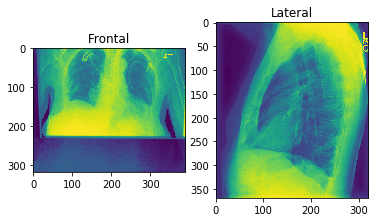

In [108]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# image saved as numpy array
fig, axs = plt.subplots(ncols=2)
axs[0].set_title('Frontal')
frontal = mpimg.imread('dev_dataset/CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg')
axs[0].imshow(frontal)
axs[1].set_title('Lateral')
lateral = mpimg.imread('dev_dataset/CheXpert-v1.0-small/train/patient00097/study1/view2_lateral.jpg')
axs[1].imshow(lateral)
plt.show()

We load the pictures into a numpy array so we can later calculate mean images, do color analysis, etc.

In [109]:
# when doing this with the train data the IOPub data rate is exceeded, hence we use valid for now
import os 
import numpy as np
lateral_list = []
frontal_list = []
patients = os.listdir('dev_dataset/CheXpert-v1.0-small/valid')
for patient in patients:
    studies = os.listdir(os.path.join('dev_dataset/CheXpert-v1.0-small/valid', patient))
    for study in studies:
        views = os.listdir(os.path.join('dev_dataset/CheXpert-v1.0-small/valid', patient, study))
        for view in views:
            path = os.path.join('dev_dataset/CheXpert-v1.0-small/valid', patient, study, view)
            if 'lateral' in view:
                lateral_list.append(mpimg.imread(path))
            else:
                frontal_list.append(mpimg.imread(path))
print('# of dimensions in one picture:', frontal_list[0].ndim)

# of dimensions in one picture: 2


The pictures in the dataset are of varying size, so we take a look at the dimensions of the images. This information needs to be
considered when preprocessing the dataset.

In [110]:
frontal_dimensions = []
for img in frontal_list:
    dim = (len(img), len(img[0]))
    if dim not in frontal_dimensions:
        frontal_dimensions.append(dim)
print('dimensions of frontal images:')
print(frontal_dimensions)

lateral_dimensions = []
for img in lateral_list:
    dim = (len(img), len(img[0]))
    if dim not in lateral_dimensions:
        lateral_dimensions.append(dim)
print('dimensions of lateral images:')
print(lateral_dimensions)

dimensions of frontal images:
[(320, 390), (320, 320), (320, 375), (372, 320), (320, 389), (320, 323), (328, 320), (320, 369), (329, 320), (320, 397), (320, 321), (333, 320), (320, 396), (320, 332), (320, 357), (320, 383), (320, 373), (320, 341), (320, 384), (320, 379), (320, 378), (320, 352), (320, 368)]
dimensions of lateral images:
[(369, 320), (374, 320), (320, 320), (390, 320), (380, 320), (377, 320), (329, 320), (401, 320), (368, 320), (433, 320), (324, 320), (389, 320)]


In [111]:
# color analysis

In [112]:
# calculate mean image ?

In [113]:
# eigenimages
